```Author: Kutsal Baran Özkurt ```

### Dependecies

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm

from confusion_mat import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from albumentations import *

from sklearn.model_selection import StratifiedKFold
from skmultilearn.model_selection import IterativeStratification

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model, Model

### Hyper-Parameters

In [2]:
SHAPE            = (224, 224, 3)
BATCH_SIZE       = 16
EPOCHS           = 100
N_SPLITS         = 3
SEED             = 1881
TRAIN_TEST_RATIO = 0.5

BASE_DIR = "data/covid-chestxray-dataset"

In [3]:
metadata = pd.read_csv(os.path.join(BASE_DIR,"metadata.csv"))
metadata.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


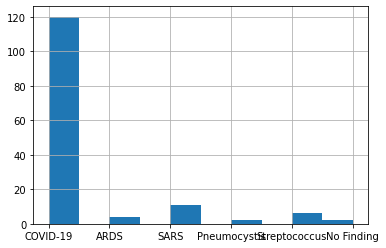

In [4]:
metadata['finding'].hist()

### Data Loader

In [5]:
class COVID19_DATASET:
    
    """
    metadata              --> pandas.DataFrame. refer -> https://github.com/ieee8023/covid-chestxray-dataset/blob/master/metadata.csv
    input_shape           --> TUPLE. Target image size
    batch_size            --> INT. Yielding data size for every iteration
    orders                --> LIST. Which images will be used. max=>len(all_images).
    base_dir              --> STR. Relative path of data directory.
    seed                  --> INT. This makes dataset generator more reproduciable 
    train_test_ratio      --> FLOAT. How much of data will be used as test set.
    augment               --> BOOL. Augment data or not.
    """
    
    def __init__(self, metadata, input_shape, batch_size, orders, base_dir, seed, train_test_ratio, augment=True):
        self.METADATA   = metadata          
        self.SHAPE      = input_shape
        self.BATCH_SIZE = batch_size
        self.arr        = orders
        self.SEED       = seed
        self.TT_RATIO   = train_test_ratio
        self.AUG        = augment
        
        self.BASE_DIR   = base_dir
        
        self.unique_labels, self.label_counts = self.get_unique_labels()
        
        self.hard_aug_probs = [0.5, 0.5, 0.7, 0.7]
        self.hard_aug_limits = [0.3,0.3,30]
        
        self.light_aug_probs = [0.5, 0.5, 0.3, 0.3]
        self.light_aug_limits = [0.1,0.1,10]
    
    def get_unique_labels(self):
        labels = []
        for f_name in os.listdir(os.path.join(self.BASE_DIR, "images")):
            get_data_row = self.METADATA[self.METADATA["filename"]==f_name]
            if not get_data_row.empty:
                labels.append(get_data_row['finding'].values)
        return np.unique(labels, return_counts=True)
    
    def get_paths_n_labels(self):
        paths = []
        y = []
        
        for f_name in os.listdir(os.path.join(self.BASE_DIR, "images")):
            get_data_row = self.METADATA[self.METADATA["filename"]==f_name]
            if not get_data_row.empty:
                # One-Hot Encoding
                label = np.zeros((len(self.unique_labels)))
                label_idx = np.where(get_data_row['finding'].values==self.unique_labels)[0][0]
                label[label_idx] = 1
                y.append(label)

                paths.append(os.path.join(self.BASE_DIR, "images", f_name))
            
        return paths, y
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def augmenting(self, img, aug_probs, aug_limits):
        if self.AUG:
            augment = Compose([HorizontalFlip(p=aug_probs[0]),
                               CLAHE(p=aug_probs[1]),
                               RandomBrightnessContrast(p=aug_probs[2]),
                               ShiftScaleRotate(p=aug_probs[3], shift_limit=aug_limits[0], scale_limit=aug_limits[1], rotate_limit=aug_limits[2])])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
        
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, y_train, x_test, y_test = self.iterative_train_test_split(np.array(img_paths), np.array(labels), test_size=self.TT_RATIO)
        
        if get=='train':
            return x_train, y_train
        
        elif get=='test':
            return x_test, y_test
        
    def iterative_train_test_split(self, X, y, test_size):
        """Iteratively stratified train/test split
        Parameters
        ----------
        test_size : float, [0,1]
            the proportion of the dataset to include in the test split, the rest will be put in the train set
        Returns
        -------
        X_train, y_train, X_test, y_test
            stratified division into train/test split
        """

        stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
        train_indexes, test_indexes = next(stratifier.split(y, y))
        
        X_train, y_train = X[train_indexes], y[train_indexes]
        X_test, y_test = X[test_indexes], y[test_indexes]

        return X_train, y_train, X_test, y_test

    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x_batch = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y_batch = np.empty((self.BATCH_SIZE, len(self.unique_labels)), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                
                # y 
                label = labels[id_]
                
                # x
                img_path = img_paths[id_]
                img = cv2.imread(img_path)
                
                if not np.squeeze(np.where(self.unique_labels=='COVID-19'))==np.squeeze(np.where(label==max(label))):
                    img = self.augmenting(img, self.hard_aug_probs, self.hard_aug_limits)
                else:
                    img = self.augmenting(img, self.light_aug_probs, self.light_aug_limits)
                
                img = cv2.resize(img, self.SHAPE[:2])
                img = np.divide(img,255)

                # Store the values    
                x_batch[ix] = img
                y_batch[ix] = label

            yield x_batch, y_batch

[[[0.9647059  0.9647059  0.9647059 ]
  [0.8784314  0.8784314  0.8784314 ]
  [0.90588236 0.90588236 0.90588236]
  ...
  [0.7921569  0.7921569  0.7921569 ]
  [0.8117647  0.8117647  0.8117647 ]
  [0.9372549  0.9372549  0.9372549 ]]

 [[0.62352943 0.62352943 0.62352943]
  [0.21568628 0.21568628 0.21568628]
  [0.24313726 0.24313726 0.24313726]
  ...
  [0.44313726 0.44313726 0.44313726]
  [0.2509804  0.25490198 0.2509804 ]
  [0.47843137 0.47843137 0.47843137]]

 [[0.60784316 0.60784316 0.60784316]
  [0.14117648 0.14117648 0.14117648]
  [0.15294118 0.15686275 0.15294118]
  ...
  [0.7294118  0.7294118  0.7294118 ]
  [0.43529412 0.43529412 0.43529412]
  [0.49803922 0.49803922 0.49803922]]

 ...

 [[0.9254902  0.9254902  0.9254902 ]
  [0.84313726 0.84313726 0.84313726]
  [0.74509805 0.74509805 0.74509805]
  ...
  [0.8039216  0.8039216  0.8039216 ]
  [0.7882353  0.7882353  0.7882353 ]
  [0.92156863 0.92156863 0.92156863]]

 [[0.87058824 0.87058824 0.87058824]
  [0.7137255  0.7137255  0.7137255 ]


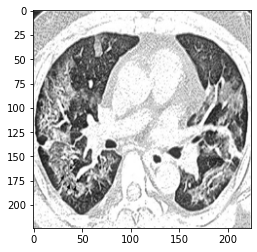

In [6]:
sample_dataset = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, range(1), BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=True)

for ix, data in enumerate(sample_dataset.data_generator()):
    img_batch, label_batch = data
    print(img_batch[0])
    print(img_batch[0].shape)
    print("-"*10)
    print(label_batch[0])
    print(label_batch[0].shape)
    print("-"*10)
    plt.imshow(img_batch[0])
    plt.show()
    
    if ix==0:
        break

### Metrics

In [7]:
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

### Learning Rate Scheduler

In [8]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

## BreastNet

### Citation
```
M. Togaçar, K.B. Özkurt, B. Ergen et al., BreastNet: A novel ˘
convolutional neural network model through histopathological images for the diagnosis of breast
cancer, Physica A (2019), doi: https://doi.org/10.1016/j.physa.2019.123592.
```

In [9]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [10]:
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [11]:
def create_model(out_neuron_number):
    
    dropRate = 0.5
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(out_neuron_number, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [12]:
model = create_model(len(sample_dataset.unique_labels))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Training

In [13]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)
x_t, y_t = sample_dataset.split_train_test("train")
for ix, (train_index, val_index) in enumerate(skf.split(x_t, y_t.argmax(1))):
                                               
    tg = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, train_index, BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=True)
    vg = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, val_index  , BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=10,
                             mult_factor=2.)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc'])
    
    if not os.path.exists("models"):
        os.makedirs("models")
        
    model_ckpt = "models/BREASTNET_COVID19_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir=os.path.join("logs",f"log_{str(ix)}"), update_freq='epoch'), 
                 schedule] 
    
    
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index),
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(val_index)//BATCH_SIZE if len(val_index)//BATCH_SIZE else 1,
                        callbacks=callbacks)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.54963, saving model to models/BREASTNET_COVID19_FOLD_0.h5
48/48 - 30s - loss: 0.8951 - precision: 0.7794 - recall: 0.6328 - f1: 0.6797 - acc: 0.7318 - val_loss: 1.5496 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_acc: 0.5000
Epoch 2/100

Epoch 00002: val_loss improved from 1.54963 to 1.30640, saving model to models/BREASTNET_COVID19_FOLD_0.h5
48/48 - 28s - loss: 0.5719 - precision: 0.8434 - recall: 0.8281 - f1: 0.8354 - acc: 0.8411 - val_loss: 1.3064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_acc: 0.8125
Epoch 3/100

Epoch 00003: val_loss improved from 1.30640 to 1.30057, saving model to models/BREASTNET_COVID19_FOLD_0.h5
48/48 - 26s - loss: 0.4797 - precision: 0.8882 - recall: 0.8659 - f1: 0.8766 - acc: 0.8828 - val_loss: 1.3006 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_acc: 0.8750
Epoch 4/100

Epoch 00004: val_loss imp

Epoch 30/100

Epoch 00030: val_loss did not improve from 0.00000
48/48 - 26s - loss: 0.2768 - precision: 0.9302 - recall: 0.8893 - f1: 0.9087 - acc: 0.9154 - val_loss: 0.8486 - val_precision: 0.7857 - val_recall: 0.6875 - val_f1: 0.7333 - val_acc: 0.7500
Epoch 31/100

Epoch 00031: val_loss did not improve from 0.00000
48/48 - 28s - loss: 0.2901 - precision: 0.9381 - recall: 0.8945 - f1: 0.9151 - acc: 0.9154 - val_loss: 0.6022 - val_precision: 0.9333 - val_recall: 0.8750 - val_f1: 0.9032 - val_acc: 0.8750
Epoch 32/100

Epoch 00032: val_loss did not improve from 0.00000
48/48 - 27s - loss: 0.2824 - precision: 0.9309 - recall: 0.8815 - f1: 0.9045 - acc: 0.8997 - val_loss: 1.0045 - val_precision: 0.6250 - val_recall: 0.6250 - val_f1: 0.6250 - val_acc: 0.6250
Epoch 33/100

Epoch 00033: val_loss did not improve from 0.00000
48/48 - 27s - loss: 0.2412 - precision: 0.9460 - recall: 0.9076 - f1: 0.9256 - acc: 0.9271 - val_loss: 0.8920 - val_precision: 0.8000 - val_recall: 0.7500 - val_f1: 0.774

Epoch 00094: val_loss did not improve from 0.00000
48/48 - 29s - loss: 0.1808 - precision: 0.9505 - recall: 0.9440 - f1: 0.9471 - acc: 0.9466 - val_loss: 1.1696 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.8750 - val_acc: 0.8750
Epoch 95/100

Epoch 00095: val_loss did not improve from 0.00000
48/48 - 29s - loss: 0.1720 - precision: 0.9510 - recall: 0.9349 - f1: 0.9427 - acc: 0.9375 - val_loss: 0.4917 - val_precision: 0.8000 - val_recall: 0.7500 - val_f1: 0.7742 - val_acc: 0.7500
Epoch 96/100

Epoch 00096: val_loss did not improve from 0.00000
48/48 - 29s - loss: 0.1058 - precision: 0.9725 - recall: 0.9635 - f1: 0.9679 - acc: 0.9674 - val_loss: 0.9837 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.8750 - val_acc: 0.8750
Epoch 97/100

Epoch 00097: val_loss did not improve from 0.00000
48/48 - 27s - loss: 0.0763 - precision: 0.9791 - recall: 0.9714 - f1: 0.9751 - acc: 0.9792 - val_loss: 0.5532 - val_precision: 0.8125 - val_recall: 0.8125 - val_f1: 0.8125 - val_acc: 0

Epoch 26/100

Epoch 00026: val_loss did not improve from 0.00019
48/48 - 30s - loss: 0.1239 - precision: 0.9647 - recall: 0.9492 - f1: 0.9566 - acc: 0.9557 - val_loss: 1.0079 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_acc: 0.9375
Epoch 27/100

Epoch 00027: val_loss did not improve from 0.00019
48/48 - 31s - loss: 0.1670 - precision: 0.9526 - recall: 0.9414 - f1: 0.9468 - acc: 0.9466 - val_loss: 0.3609 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0.7500
Epoch 28/100

Epoch 00028: val_loss did not improve from 0.00019
48/48 - 27s - loss: 0.1825 - precision: 0.9550 - recall: 0.9427 - f1: 0.9486 - acc: 0.9505 - val_loss: 1.0241 - val_precision: 0.9333 - val_recall: 0.8750 - val_f1: 0.9032 - val_acc: 0.8750
Epoch 29/100

Epoch 00029: val_loss did not improve from 0.00019
48/48 - 30s - loss: 0.1298 - precision: 0.9645 - recall: 0.9531 - f1: 0.9585 - acc: 0.9570 - val_loss: 2.8083 - val_precision: 0.6875 - val_recall: 0.6875 - val_f1: 0.687

Epoch 00090: val_loss did not improve from 0.00019
48/48 - 33s - loss: 0.0914 - precision: 0.9752 - recall: 0.9622 - f1: 0.9684 - acc: 0.9701 - val_loss: 0.9436 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_acc: 0.9375
Epoch 91/100

Epoch 00091: val_loss did not improve from 0.00019
48/48 - 31s - loss: 0.1015 - precision: 0.9751 - recall: 0.9714 - f1: 0.9732 - acc: 0.9727 - val_loss: 0.0528 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000
Epoch 92/100

Epoch 00092: val_loss did not improve from 0.00019
48/48 - 29s - loss: 0.0935 - precision: 0.9752 - recall: 0.9688 - f1: 0.9719 - acc: 0.9714 - val_loss: 1.0078 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_acc: 0.9375
Epoch 93/100

Epoch 00093: val_loss did not improve from 0.00019
48/48 - 33s - loss: 0.1049 - precision: 0.9688 - recall: 0.9648 - f1: 0.9667 - acc: 0.9661 - val_loss: 2.2318 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0

Epoch 21/100

Epoch 00021: val_loss did not improve from 0.00166
48/48 - 27s - loss: 0.0898 - precision: 0.9775 - recall: 0.9674 - f1: 0.9722 - acc: 0.9714 - val_loss: 0.0363 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000
Epoch 22/100

Epoch 00022: val_loss did not improve from 0.00166
48/48 - 29s - loss: 0.1066 - precision: 0.9735 - recall: 0.9661 - f1: 0.9697 - acc: 0.9714 - val_loss: 1.6834 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0.7500
Epoch 23/100

Epoch 00023: val_loss did not improve from 0.00166
48/48 - 27s - loss: 0.0822 - precision: 0.9751 - recall: 0.9661 - f1: 0.9705 - acc: 0.9661 - val_loss: 3.0221 - val_precision: 0.8125 - val_recall: 0.8125 - val_f1: 0.8125 - val_acc: 0.8125
Epoch 24/100

Epoch 00024: val_loss did not improve from 0.00166
48/48 - 27s - loss: 0.0790 - precision: 0.9802 - recall: 0.9701 - f1: 0.9748 - acc: 0.9727 - val_loss: 1.1062 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1: 0.875

Epoch 85/100

Epoch 00085: val_loss did not improve from 0.00001
48/48 - 25s - loss: 0.0224 - precision: 0.9961 - recall: 0.9948 - f1: 0.9954 - acc: 0.9961 - val_loss: 0.7223 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_acc: 0.9375
Epoch 86/100

Epoch 00086: val_loss did not improve from 0.00001
48/48 - 28s - loss: 0.0222 - precision: 0.9935 - recall: 0.9922 - f1: 0.9928 - acc: 0.9922 - val_loss: 1.6014 - val_precision: 0.7500 - val_recall: 0.7500 - val_f1: 0.7500 - val_acc: 0.7500
Epoch 87/100

Epoch 00087: val_loss did not improve from 0.00001
48/48 - 26s - loss: 0.0379 - precision: 0.9869 - recall: 0.9844 - f1: 0.9856 - acc: 0.9870 - val_loss: 0.1465 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_acc: 0.9375
Epoch 88/100

Epoch 00088: val_loss did not improve from 0.00001
48/48 - 28s - loss: 0.0395 - precision: 0.9922 - recall: 0.9909 - f1: 0.9915 - acc: 0.9922 - val_loss: 0.7204 - val_precision: 0.8125 - val_recall: 0.8125 - val_f1: 0.812

### Testing

In [14]:
gen = COVID19_DATASET(metadata, SHAPE, BATCH_SIZE, range(1), BASE_DIR, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
x_test = np.zeros((len(gen[0]),)+SHAPE, dtype=np.float32)
y_test = np.zeros((len(gen[1]), len(sample_dataset.unique_labels)), dtype=np.float32)

for ix, path in tqdm(enumerate(gen[0])):
    img = cv2.imread(path)
    img = cv2.resize(img, SHAPE[:2])
    img = np.divide(img,255)

    label = gen[1][ix]

    x_test[ix] = img
    y_test[ix] = label

73it [00:01, 36.70it/s]


In [15]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

### Get Results

In [16]:
models = []
scores = []
for i in range(N_SPLITS):
    model = load_model("models/BREASTNET_COVID19_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)
    scores.append(score[-1])
    models.append(model)

[3.555260762776414, 0.8379629, 0.8379629, 0.8379629, 0.82191783]
[2.703720693718897, 0.8587963, 0.8587963, 0.8587963, 0.84931505]
[2.633452644086864, 0.8379629, 0.8379629, 0.8379629, 0.82191783]


In [17]:
best_model_idx = np.array(scores).argmax()
best_model = models[best_model_idx]
print(best_model_idx)

1


In [18]:
y_preds = threshold_arr(best_model.predict(x_test, verbose=0))

ROC_AUC: 0.9095890410958903, Accuracy: 0.8493150684931506, F1_Score: 0.8493150684931505, Precision: 0.8493150684931506, Recall: 0.8493150684931506


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.85      1.00      0.92        60
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      0.33      0.50         6
           5       0.00      0.00      0.00         3

   micro avg       0.85      0.85      0.85        73
   macro avg       0.31      0.22      0.24        73
weighted avg       0.78      0.85      0.79        73
 samples avg       0.85      0.85      0.85        73





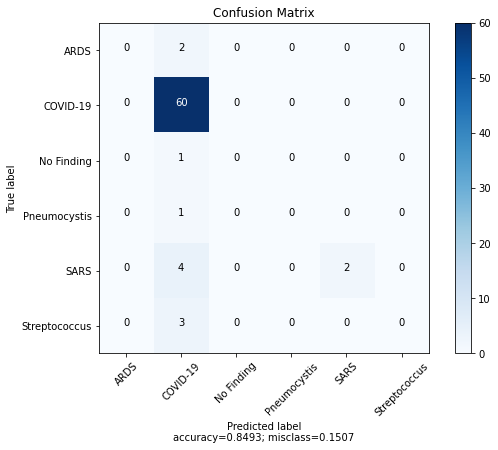

In [19]:
results = precision_recall_fscore_support(y_test, y_preds, average='micro')
acc = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds, average='micro')

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y_test, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      desc         = f"{best_model_idx+1}. FOLD (BEST) - Multiclass",
                      normalize    = False,
                      target_names = sample_dataset.unique_labels,
                      title        = "Confusion Matrix")

### BREASTNET-COVID-19 Convert Predictions to Binary Classification (COVID-19 or NOT)

In [20]:
covid_ord = np.where(sample_dataset.unique_labels=='COVID-19')[0][0]

In [21]:
bin_labels = []
for pred in y_test:
    if pred.argmax() == covid_ord:
        binary_label = 1
    else:
        binary_label = 0
    bin_labels.append(binary_label)
    
bin_preds = []
for pred in y_preds:
    if pred.argmax() == covid_ord:
        binary_label = 1
    else:
        binary_label = 0
    bin_preds.append(binary_label)

ROC_AUC: 0.5769230769230769, Accuracy: 0.8493150684931506, F1_Score: 0.916030534351145, Precision: 0.8450704225352113, Recall: 1.0


              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.85      1.00      0.92        60

    accuracy                           0.85        73
   macro avg       0.92      0.58      0.59        73
weighted avg       0.87      0.85      0.80        73





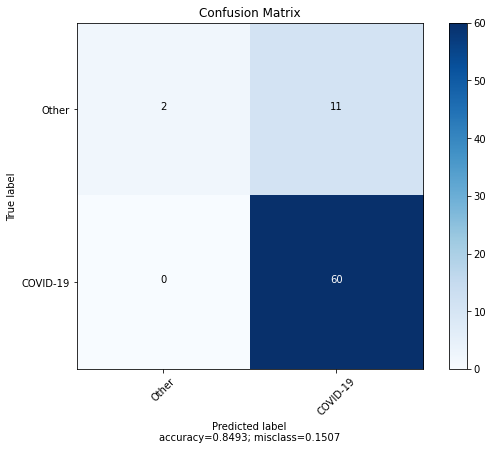

In [22]:
results = precision_recall_fscore_support(bin_labels, bin_preds, average='binary')
acc = accuracy_score(bin_labels, bin_preds)
roc_auc = roc_auc_score(bin_labels, bin_preds)

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(bin_labels, bin_preds))
print("\n")
cnf_matrix = confusion_matrix(bin_labels, bin_preds)

plot_confusion_matrix(cm           = cnf_matrix, 
                      desc         = f"{best_model_idx+1}. FOLD - Binary",
                      normalize    = False,
                      target_names = ['Other','COVID-19'],
                      title        = "Confusion Matrix")

### Basic Speed Test on _NVIDIA_GTX_1070_

In [23]:
import time
for i in range(5): 
    img = cv2.imread(os.path.join(BASE_DIR,"images/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg"))
    x = cv2.resize(img, SHAPE[:2])
    x = np.divide(x, 255)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = best_model.predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[0. 1. 0. 0. 0. 0.]]
667.9673194885254 ms
***
[[0. 1. 0. 0. 0. 0.]]
31.002283096313477 ms
***
[[0. 1. 0. 0. 0. 0.]]
30.95698356628418 ms
***
[[0. 1. 0. 0. 0. 0.]]
31.960010528564453 ms
***
[[0. 1. 0. 0. 0. 0.]]
34.99913215637207 ms
***
